## 1. Import Modules

In [1]:
import numpy as np
import pandas as pd # import library for data analysis

from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns # for nicer plots
sns.set_theme('talk', style = 'white')


## 2. Data Collection & Cleaning

### 2.1 Load Data from Excel Table

In [2]:
data = pd.read_excel('Data/pwt110_download_2025_11_24.xlsx', sheet_name = 'Data', header = 0)

### 2.2 Clean Data

#### 2.2.1  Construct Price Index for Scaling

In [3]:
# Define price index
data["price_index"] = data["cgdpe"] / data["rgdpe"]
# Calculate the price index of 2017 and 2021
P_2017 = (
    data.loc[data["year"] == 2017, ["country", "price_index"]]
    .set_index("country")
)

P_2021 = (
    data.loc[data["year"] == 2021, ["country", "price_index"]]
    .set_index("country")
)

#### 2.2.2 Filter Data and Change the Base Year from 2021 to 2017

In [4]:
# Filter data by columns. We need country, year, real gdp, population, real capital, human capital and employment)
data_filtered = data.loc[:, ("country", "year", "rgdpe", "pop","rnna", "hc", "emp","rgdpna")]
#Drop empty values
data_filtered = data_filtered.dropna(subset=["rgdpe", "pop"])

# Calculate real dgp per person
data_filtered["rgdpe_pc"] = data_filtered["rgdpe"] / data_filtered["pop"]

# select Chile as a country
data_Chile = data_filtered.loc[data_filtered["country"] == "Chile"].copy()
# Changing base year 2021 to 2017 of rdgpe, rnna, and rgdpe_pc
scale = (
    P_2021.loc["Chile", "price_index"] /
    P_2017.loc["Chile", "price_index"]
)

cols_to_rebase = ["rgdpe", "rnna","rgdpe_pc","rgdpna"]

for col in cols_to_rebase:
    data_Chile[col] = data_Chile[col]*scale
# Reset the index
data_Chile = data_Chile.reset_index(drop = True)

In [5]:
# Subset the RGDP per capita series
ymax = 2023
ymin = 1951 # Starting at 1951 because data for Chile in 1950 is unavailable.

# We use logical indexing to subset the data to rows of years ymin <= year <= ymax
y = data_Chile.loc[np.logical_and(data_Chile["year"] <= ymax, data_Chile["year"] >= ymin), "rgdpe_pc"]
Y = data_Chile.loc[np.logical_and(data_Chile["year"] <= ymax, data_Chile["year"] >= ymin), "rgdpe"]
lgy = np.log(y)
lgY = np.log(Y)
data_Chile = data_Chile[data_Chile["year"] >= ymin] # we keep only years after ymin

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T = len(Y) # sample size used for regression
T_all = data_Chile["year"].max() - (ymin - 1) # number of all years in the data after ymin

## 3. Trend Calculation

Justification of using exponential linear model for rGDP and rGDPpc trend regression:
- We focus on log-linear (exponential) trends because long-run growth is best interpreted in terms of growth rates rather than levels; additive specifications impose implausible long-run dynamics for Chile, and higher-order log trends provide no additional insight beyond a linear specification.

In [6]:
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is vector 1, 4, 9, ..., T^2.
# The dependent variable is per capita GDP in *levels*

x1 = np.empty(T) # initialise an empty vector for the first regressor
x2 = np.empty(T) # initialise an empty vector for the second regressor
x3 = np.empty(T) #initialise an empty vector for the third regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1 # recall that Python starts indexing at 0
    x3[t] = (t + 1)**2


### 3.1 The Trend of real GDP per capita

In [7]:
# Model: log(yt) = a + bt
a_exp_lin, b_exp_lin = get_regression_coefs(lgy, x1, x2)

In [8]:
# Initialise predicted values yhat
lgyhat_exp_lin = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    lgyhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1)


### 3.2 The Trend of real GDP

In [9]:
# Model: log(Yt) = a + bt
a_exp_lin, b_exp_lin = get_regression_coefs(lgY, x1, x2)

In [10]:
# Initialise predicted values yhat
lgYhat_exp_lin = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    lgYhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1)

### 3.3 Plot the Figure with log real GDP and log real GDP per capita

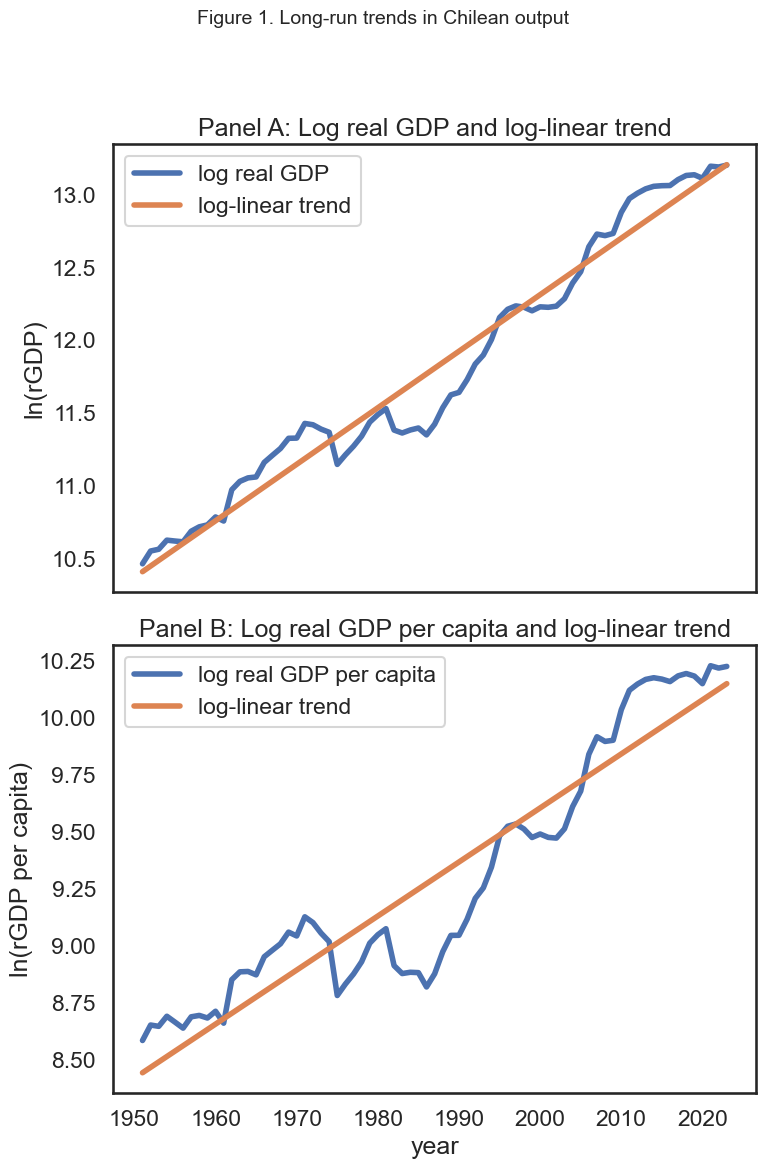

In [11]:
lw = 4

fig, axes = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

# ---------- Panel A: rGDP ----------
axes[0].plot(
    data_Chile['year'],
    np.log(data_Chile['rgdpe']),
    label='log real GDP',
    linewidth=lw
)
axes[0].plot(
    data_Chile['year'],
    lgYhat_exp_lin,
    label='log-linear trend',
    linewidth=lw
)

axes[0].set_ylabel("ln(rGDP)")
axes[0].set_title("Panel A: Log real GDP and log-linear trend")
axes[0].legend()

# ---------- Panel B: rGDP per capita ----------
axes[1].plot(
    data_Chile['year'],
    np.log(data_Chile['rgdpe_pc']),
    label='log real GDP per capita',
    linewidth=lw
)
axes[1].plot(
    data_Chile['year'],
    lgyhat_exp_lin,
    label='log-linear trend',
    linewidth=lw
)

axes[1].set_ylabel("ln(rGDP per capita)")
axes[1].set_xlabel("year")
axes[1].set_title("Panel B: Log real GDP per capita and log-linear trend")
axes[1].legend()

# ---------- Overall figure title ----------
fig.suptitle("Figure 1. Long-run trends in Chilean output", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 4. Extract TFP Measure

To extract a measure of total factor productivity (TFP), we assume a Cobb–Douglas production function with constant returns to scale. Output is produced using physical capital, labour, and human capital:

$$
Y_t = A_t K_t^{\alpha} (H_t L_t)^{1-\alpha}
$$

where:
- $Y_t$ is real GDP at constant 2017 national prices (`rgdpna`)
- $K_t$ is the real capital stock (`rnna`)
- $L_t$ is total employment (`emp`)
- $H_t$ is the human capital index (`hc`)
- $A_t$ is TFP

Following the benchmark value suggested in the project guidelines, we set $\alpha = 0.3$ (and later check robustness to alternative values). Taking natural logarithms, TFP can be obtained as a residual:

$$
\ln A_t
= \ln Y_t
- \alpha \ln K_t
- (1-\alpha)\big(\ln L_t + \ln H_t\big)
$$

This method interprets TFP as the component of output not explained by observable inputs, capturing long-run changes in productivity such as efficiency gains and technological progress. The resulting TFP series is used in subsequent analysis (growth accounting and the comparison between TFP and labour productivity).


### 4.1 Calculate TFP Series

In [12]:
# Define capital share
alpha = 0.3
# Calculate log values
data_Chile['ln_Y'] = np.log(data_Chile['rgdpna'])
data_Chile['ln_k'] = np.log(data_Chile['rnna'])
data_Chile['ln_l'] = np.log(data_Chile['emp'])

data_Chile['ln_tfp'] = (
    data_Chile['ln_Y']
    - alpha * data_Chile['ln_k']
    - (1 - alpha) * data_Chile['ln_l']
)

data_Chile['tfp'] = np.exp(data_Chile['ln_tfp'])

0      711.748557
1      737.175359
2      781.471894
3      737.871347
4      758.678127
         ...     
68    1496.454745
69    1525.653455
70    1618.285453
71    1560.071951
72    1522.511592
Name: tfp, Length: 73, dtype: float64

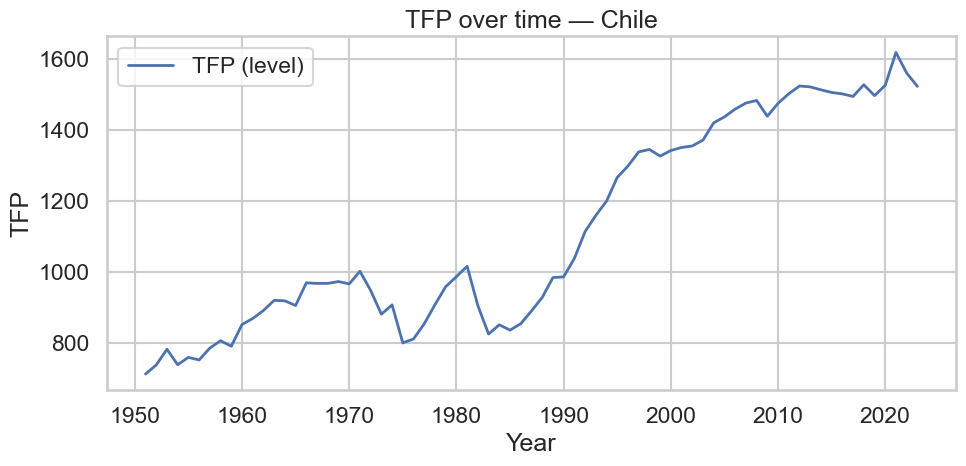

In [13]:
sns.set_theme('talk', style='whitegrid')

years = data_Chile['year']
tfp = data_Chile['tfp']

#rolling = tfp.rolling(window=5, center=True, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(years, tfp, label='TFP (level)', linewidth=2)
#ax.plot(years, rolling, label='5-year rolling mean', linewidth=2, linestyle='--')
ax.set_xlabel('Year')
ax.set_ylabel('TFP')
ax.set_title('TFP over time — Chile')
ax.legend()
ax.grid(True)
plt.tight_layout()
# fig.savefig('fig_tfp.png', dpi=300)
plt.show()


## 5. Growth Accounting